In [1]:
#pip install gekko

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

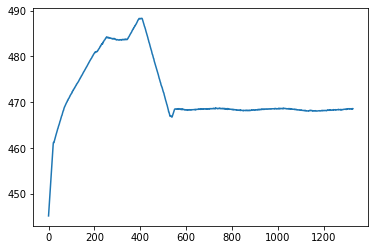

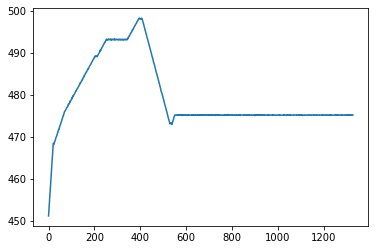

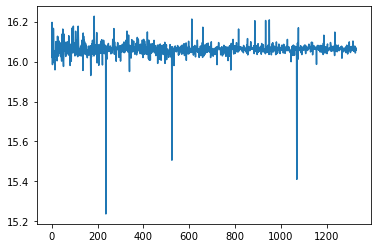

In [93]:
import pandas as pd

data = pd.read_csv('Aug4_6 Data.csv')
timeVals = data['t'].to_numpy()*60 #s
Tvals = data['Tmax'].to_numpy()+273.15
Tcvals = data['Oil T'].to_numpy()+273.15
Pvals = data['P'].to_numpy()

plt.plot(Tvals)
plt.show()

plt.plot(Tcvals)
plt.show()

plt.plot(Pvals)
plt.show()


In [94]:
data[0:-1:200]

,Timestamp,t,Oil T,Tmax,Recycle,Syngas,P,CH4 Comp,CH4 Selec
0,8/4/21 16:30,0.0,177.9612,172.0441,24.0858,8.0152,16.0213,0.4892,0.051525
200,8/5/21 9:10,1000.0,215.8301,207.5675,24.0636,6.0139,16.0494,10.0813,0.261088
400,8/6/21 1:50,2000.0,225.0552,215.1399,24.0573,6.0226,16.0774,13.0384,0.295533
600,8/6/21 21:05,3155.0,202.0191,195.1940,24.0342,3.9985,16.0402,7.2342,0.189793
800,8/7/21 13:45,4155.0,202.0309,195.3325,24.0288,3.9982,16.0408,7.2213,0.203810
1000,8/8/21 6:30,5160.0,202.0057,195.4568,24.0330,3.9977,16.0710,7.1781,0.212515
1200,8/8/21 23:10,6160.0,201.9788,195.0297,24.0351,3.9994,16.0628,6.9650,0.215013


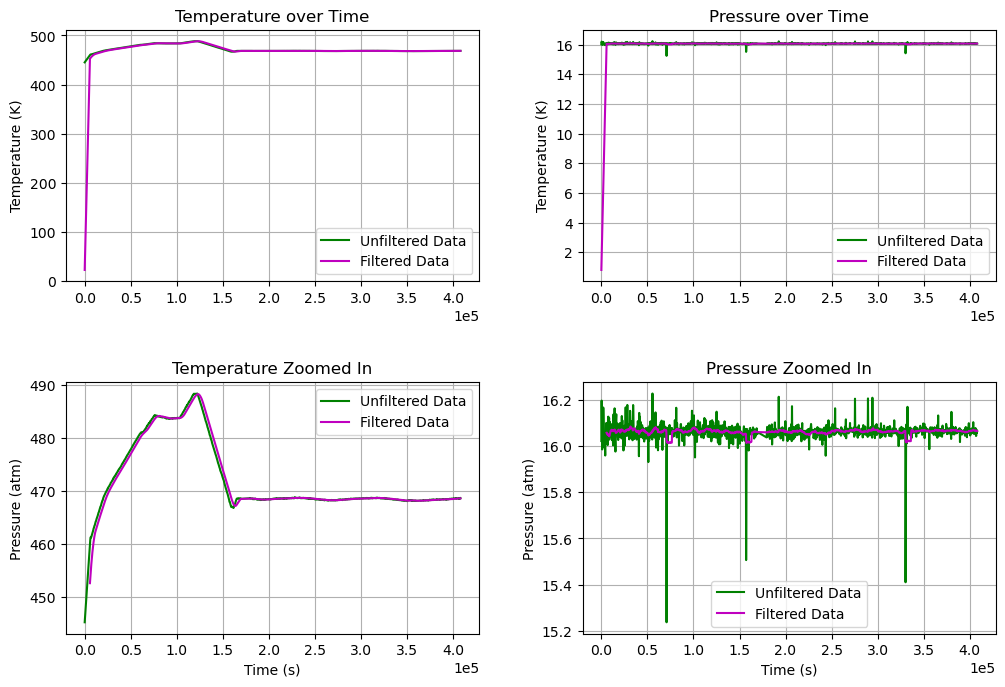

In [95]:
from scipy.signal import lfilter

n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1#Tvals[0]

Tfil = lfilter(b,a,Tvals)
Pfil = lfilter(b,a,Pvals)
fig,ax = plt.subplots(2,2,figsize=(12,8),dpi=100)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.4)

ax[0,0].set_title('Temperature over Time')
ax[0,1].set_title('Pressure over Time')
ax[1,0].set_title('Temperature Zoomed In')
ax[1,1].set_title('Pressure Zoomed In')

ax[0,0].plot(timeVals,Tvals,c='g',label='Unfiltered Data')
ax[0,0].plot(timeVals,Tfil,c='m',label='Filtered Data')

ax[1,0].plot(timeVals,Tvals,c='g',label='Unfiltered Data')
ax[1,0].plot(timeVals[19:],Tfil[19:],c='m',label='Filtered Data')

ax[0,1].plot(timeVals,Pvals,c='g',label='Unfiltered Data')
ax[0,1].plot(timeVals,Pfil,c='m',label='Filtered Data')

ax[1,1].plot(timeVals,Pvals,c='g',label='Unfiltered Data')
ax[1,1].plot(timeVals[19:],Pfil[19:],c='m',label='Filtered Data')

ax[1,0].set_xlabel('Time (s)')
ax[1,1].set_xlabel('Time (s)')

ax[0,0].set_ylabel('Temperature (K)')
ax[0,1].set_ylabel('Temperature (K)')

ax[1,0].set_ylabel('Pressure (atm)')
ax[1,1].set_ylabel('Pressure (atm)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

for i in range(2):
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].legend()
        #ax[i,j].ticklabel_format(style='sci', axis='x')
        ax[i,j].ticklabel_format(style='sci',scilimits=(-3,4),axis='x')

        

In [96]:
Pfil_org = Pfil[19:]
print(len(Pfil_org))

Pfil = np.append(Pfil[19:38],Pfil_org)
print(len(Pfil))

print(len(timeVals))
print(len(Tvals))

1310
1329
1329
1329


In [97]:
m = GEKKO()
nt = len(timeVals)#501
t = np.linspace(0,200,nt) #120*3
m.time = timeVals

In [98]:
## Reactor Properties
ρ_b = m.MV(lb=0.2*1e6,ub=1.4*1e6) #g/m3,value=0.8*1e6,
D = m.Const(value=1.5/39.37) #m
L = m.Const(value=4*12/39.37) #m
Ac = m.Intermediate(np.pi/4*D**2) #m2
V = m.Intermediate(np.pi/4*D**2*L) #m3
W = m.Intermediate(Ac*L*ρ_b) #weight of catalyst, g

## Syngas Feed
yco = m.Const(0.214)
yh2 = m.Const(0.46)
q = m.Const(value=4) #SLPM
F0 = m.Intermediate(q/0.082057/273.15/60) #mol/s
Fco = m.Intermediate(F0*yco) #mol/s
T0 = m.Const(value=210 + 273.15) #K 485.5936
## Kinetics
A = m.Const(value=3.32e7/60) #mol/g/s/atm^0.55
Ea = m.MV(value=93.8) #kJ/mol,
ΔHr = m.MV(value=-165) #kJ/mol,value=-165,const
R = m.MV(value=8.314e-3) #kJ/mol/K,,const

In [99]:
## Manipulated Variables
Tc = m.CV(Tcvals) #value=T0,lb=195+273.15
P = m.CV(Pfil)

#m.CV(Pfil) #atm,value=18,lb=15,ub=20

Tc.STATUS = 1
#Tc.FSTATUS = 0

P.STATUS = 1
#P.FSTATUS = 0

# ## Controlled Variables
# T = m.CV(value=T0,lb=205+273.15,ub=230+273.15)
# T.STATUS = 1
# T.FSTATUS = 1
# T.SP = 220 + 273.15

Cp = m.MV(lb=3500,ub=4500) #kJ/kg/K,value=53.89*74.93,
Ua = m.MV(lb=4.5e4,ub=5.5e4)#value=5e4,

T = m.CV(Tvals) #value=T0,lb=205+273.15,ub=230+273.15
T.STATUS = 1

In [100]:
## Equations
Pco = m.Intermediate(P*yco)
Ph2 = m.Intermediate(P*yh2)
r_CO = m.Intermediate(A*m.exp(-Ea/R/T)*Pco**(-0.05)*Ph2**0.6)
#X_CO = m.Intermediate(W*r_CO/Fco)
m.Equation(T.dt() == (-ΔHr)*r_CO/Cp + Ua*(Tc - T)/ρ_b/Cp/V)

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

#m.Obj(-r_CO*final)

In [101]:
m.options.IMODE = 5
m.options.SOLVER = 3

m.solve(disp=False)

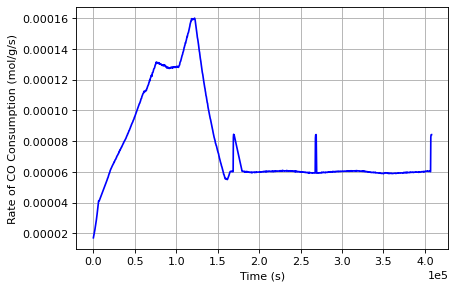

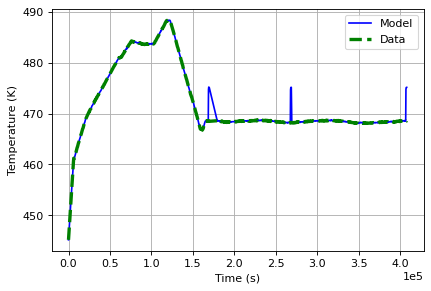

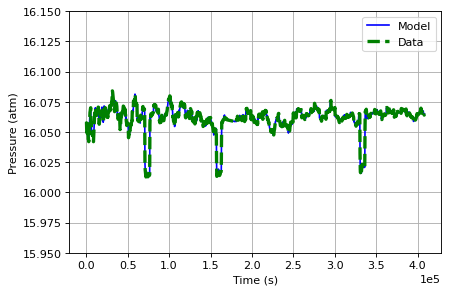

In [102]:
plt.figure(dpi=80)
plt.plot(m.time,r_CO.value,'b')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time (s)')
plt.ylabel('Rate of CO Consumption (mol/g/s)')
plt.grid()
plt.show()

plt.figure(dpi=80)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(m.time,T.value,c='b',label='Model')
plt.plot(m.time,Tvals,label='Data',c='g',ls='--',lw=3)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=80)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(m.time,P.value,c='b',label='Model')
plt.plot(m.time,Pfil,label='Data',c='g',ls='--',lw=3)
plt.ylim(15.95,16.15)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (atm)')
plt.legend()
plt.grid()
plt.show()

In [103]:
print('ρ_b = ',ρ_b.value[0])
print('Cp = ',Cp.value[0])
print('Ua = ',Ua.value[0])
print('ΔHr = ',ΔHr.value[0])
print('R = ',R.value[0])
print('Ea = ',Ea.value[0])

ρ_b =  200000.0
Cp =  3500.0
Ua =  45000.0
ΔHr =  -165.0
R =  0.008314
Ea =  93.8
